In [2]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
hdulist = fits.open('data/allStarLite-dr17-synspec_rev1.fits')


In [4]:

hdu1_data = hdulist[1].data


In [5]:
df4 = pd.DataFrame(hdu1_data.tolist(), columns=hdu1_data.names)

In [6]:
df = df4

In [26]:
physical_subset = df[["J", "H", "K", "M_H", "VMICRO", "VMACRO", "VSINI"]]

In [29]:
physical_subset.head()

,J,H,K,M_H,VMICRO,VMACRO,VSINI
0,99.999001,99.999001,99.999001,0.005657,0.412648,0.000000,4.778923
1,8.597000,7.667000,7.314000,-0.147680,1.712182,3.223484,NaN
2,11.074000,10.740000,10.670000,-0.268750,0.409694,0.000000,6.273645
3,10.905000,10.635000,10.483000,-0.245100,2.143433,0.000000,14.965801
4,10.905000,10.635000,10.483000,-0.221510,1.957898,0.000000,14.993395


In [7]:
# subset all chemical abundances (collumn name contain "_FE")
chemical_subset = df.filter(regex='_FE', axis=1) 

# merge with + df.filter(regex='_H', axis=1)
chemical_subset = pd.concat([chemical_subset, df.filter(regex='_H', axis=1)], axis=1)

In [8]:
chemical_subset['X_H'].head()

0    [0.008309399709105492, 0.014742500148713589, 0...
1    [-0.15138529241085052, -0.16750599443912506, -...
2    [-0.21379201114177704, -0.20490001142024994, -...
3    [-0.14024001359939575, -0.12852999567985535, -...
4    [-0.18151900172233582, -0.1434449851512909, -0...
Name: X_H, dtype: object

In [9]:
low_variability_columns = []

for col in df.columns:
    try:
        # Si la colonne contient moins de 5 valeurs uniques, on l'ajoute à la liste
        if df[col].nunique() < 5:
            low_variability_columns.append(col)
    except TypeError:
        print(f"error with column {col}")

print("Colonnes avec faible variabilité :", low_variability_columns)



error with column PARAMFLAG
error with column X_H
error with column X_H_ERR
error with column X_M
error with column X_M_ERR
error with column ELEM_CHI2
error with column ELEMFRAC
error with column X_H_SPEC
error with column X_M_SPEC
Colonnes avec faible variabilité : ['TELESCOPE', 'APOGEE2_TARGET4', 'RV_ALPHA', 'RV_CARB', 'MAX_JK', 'P_FE', 'P_FE_SPEC', 'CU_FE', 'CU_FE_SPEC']


In [10]:
# create an error dataset containing all errors 
chemical_errors_subset = chemical_subset.filter(regex='_ERR', axis=1)

# create an error dataset containing all specs
chemical_specs_subset = chemical_subset.filter(regex='_SPEC', axis=1)

# create a dataset containing all the flags
flags_subset = chemical_subset.filter(regex='FLAG', axis=1)

# remove flags, err and spec from the chemical_subset
chemical_subset = chemical_subset.drop(chemical_errors_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(chemical_specs_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(flags_subset.columns, axis=1)






In [11]:
chemical_subset = chemical_subset.drop(columns=['GAIAEDR3_R_HI_GEO', 'GAIAEDR3_R_HI_PHOTOGEO'])
chemical_subset = chemical_subset.drop(columns=['MAX_H', 'MIN_H', 'M_H', 'X_H', 'RV_FEH'])

In [12]:
chemical_subset = chemical_subset.drop(columns=['P_FE', 'CU_FE'])

In [13]:
chemical_specs_subset = chemical_specs_subset.drop(columns=['X_H_SPEC'])

In [14]:
# Limiter les valeurs extrêmes pour mieux voir les distributions principales
chemical_subset_filtered = chemical_subset.apply(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))

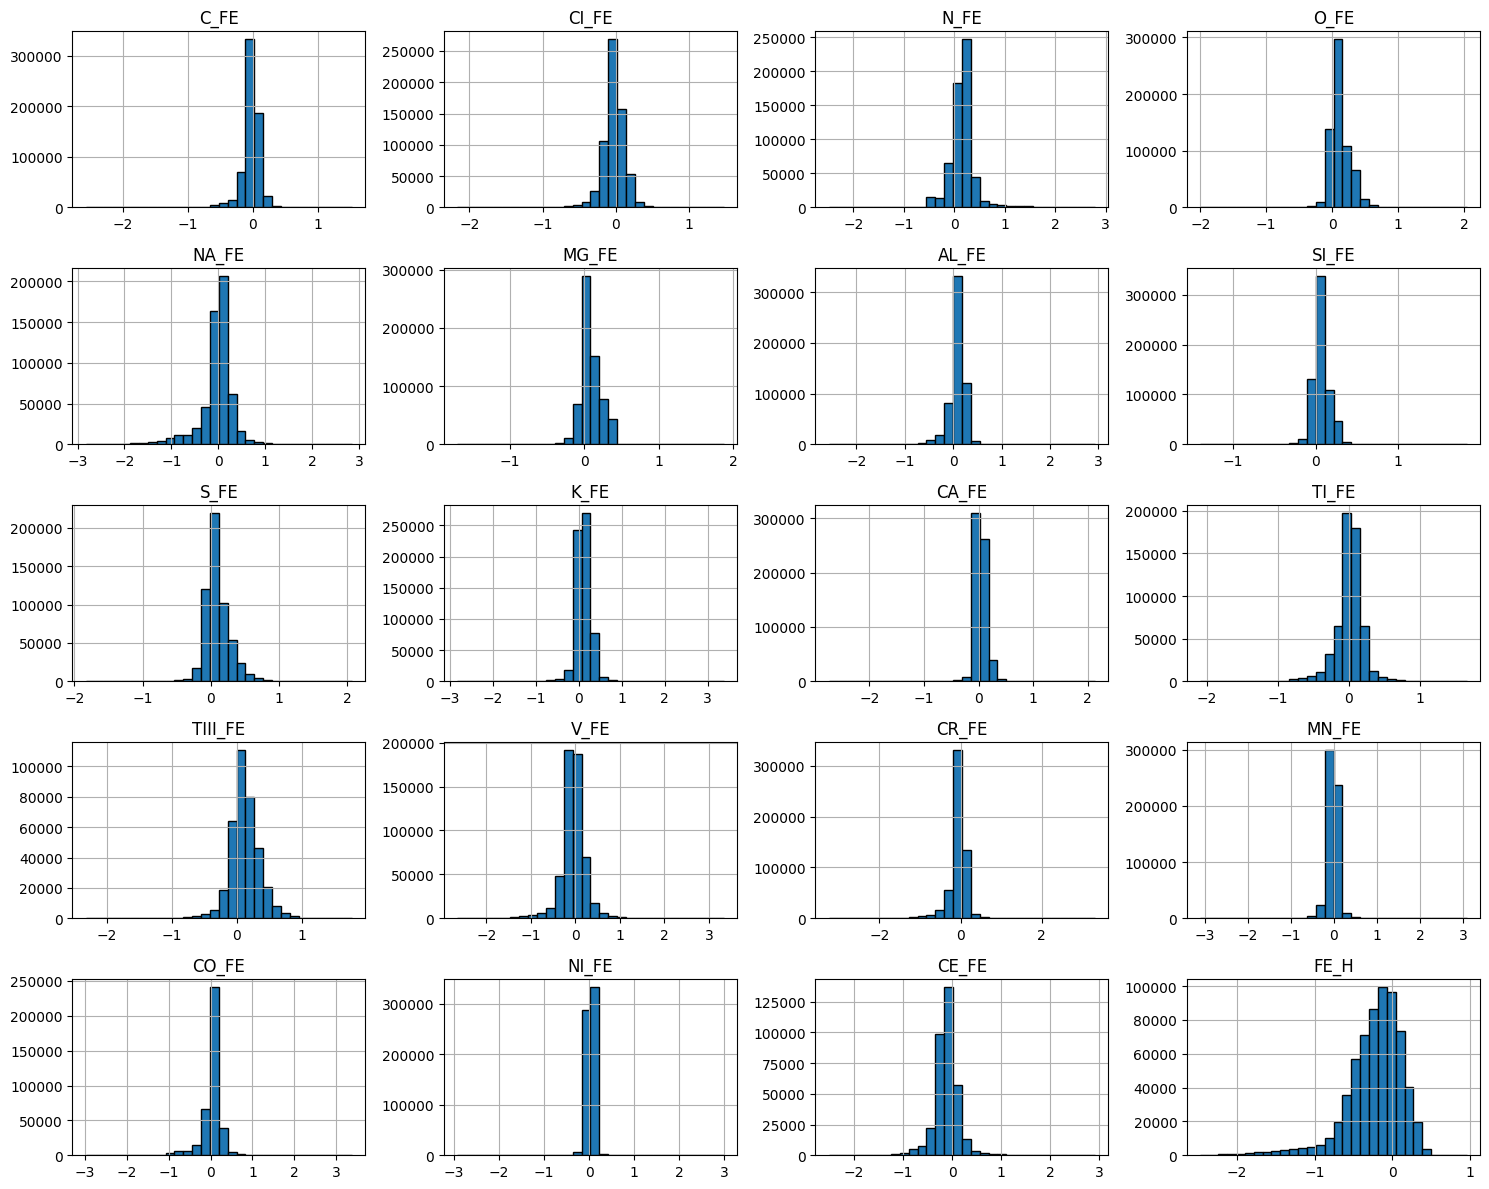

In [15]:
chemical_subset.hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


## Box plots (filtré)

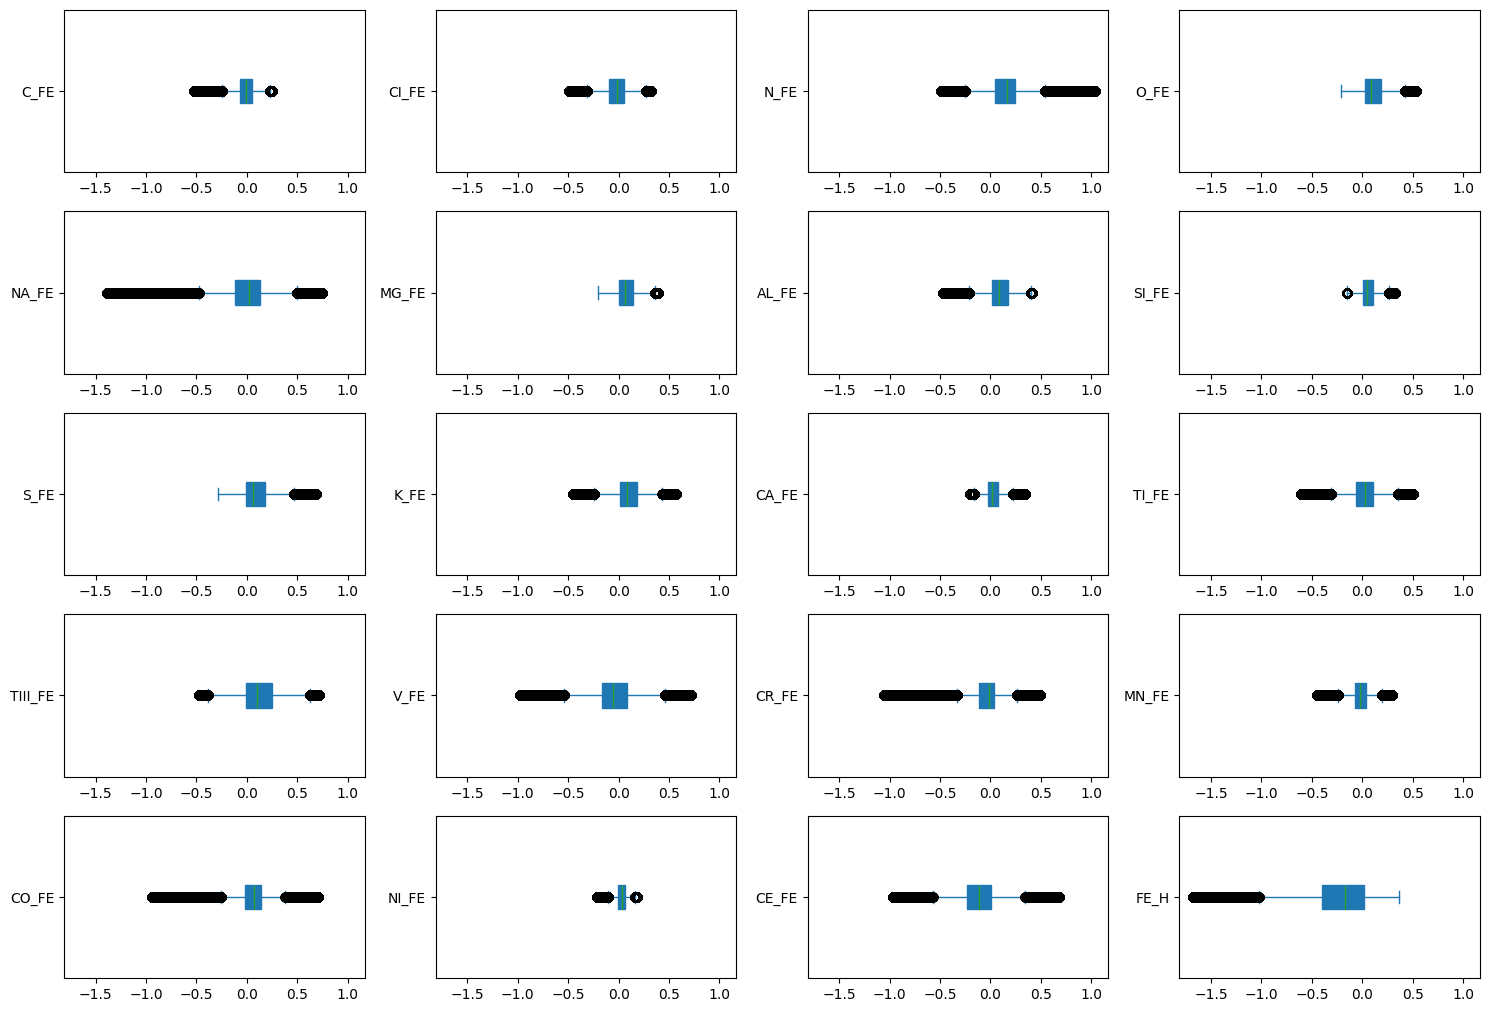

In [16]:
# Créer les boxplots en limitant les valeurs extrêmes
axes = chemical_subset_filtered.plot(kind='box', subplots=True, layout=(6, 4), figsize=(15, 12), patch_artist=True, vert=False)

# Si `axes` est une liste ou un tableau, on itère simplement dessus
for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=True)  # Afficher les étiquettes des axes x
    ax.yaxis.set_tick_params(labelleft=True)    # Afficher les étiquettes des axes y

# Rotation des étiquettes pour les rendre lisibles
plt.xticks(rotation=45)

# Ajuster l'espacement des sous-graphiques
plt.tight_layout()

# Afficher les boxplots
plt.show()



## Violin plots (filtré)

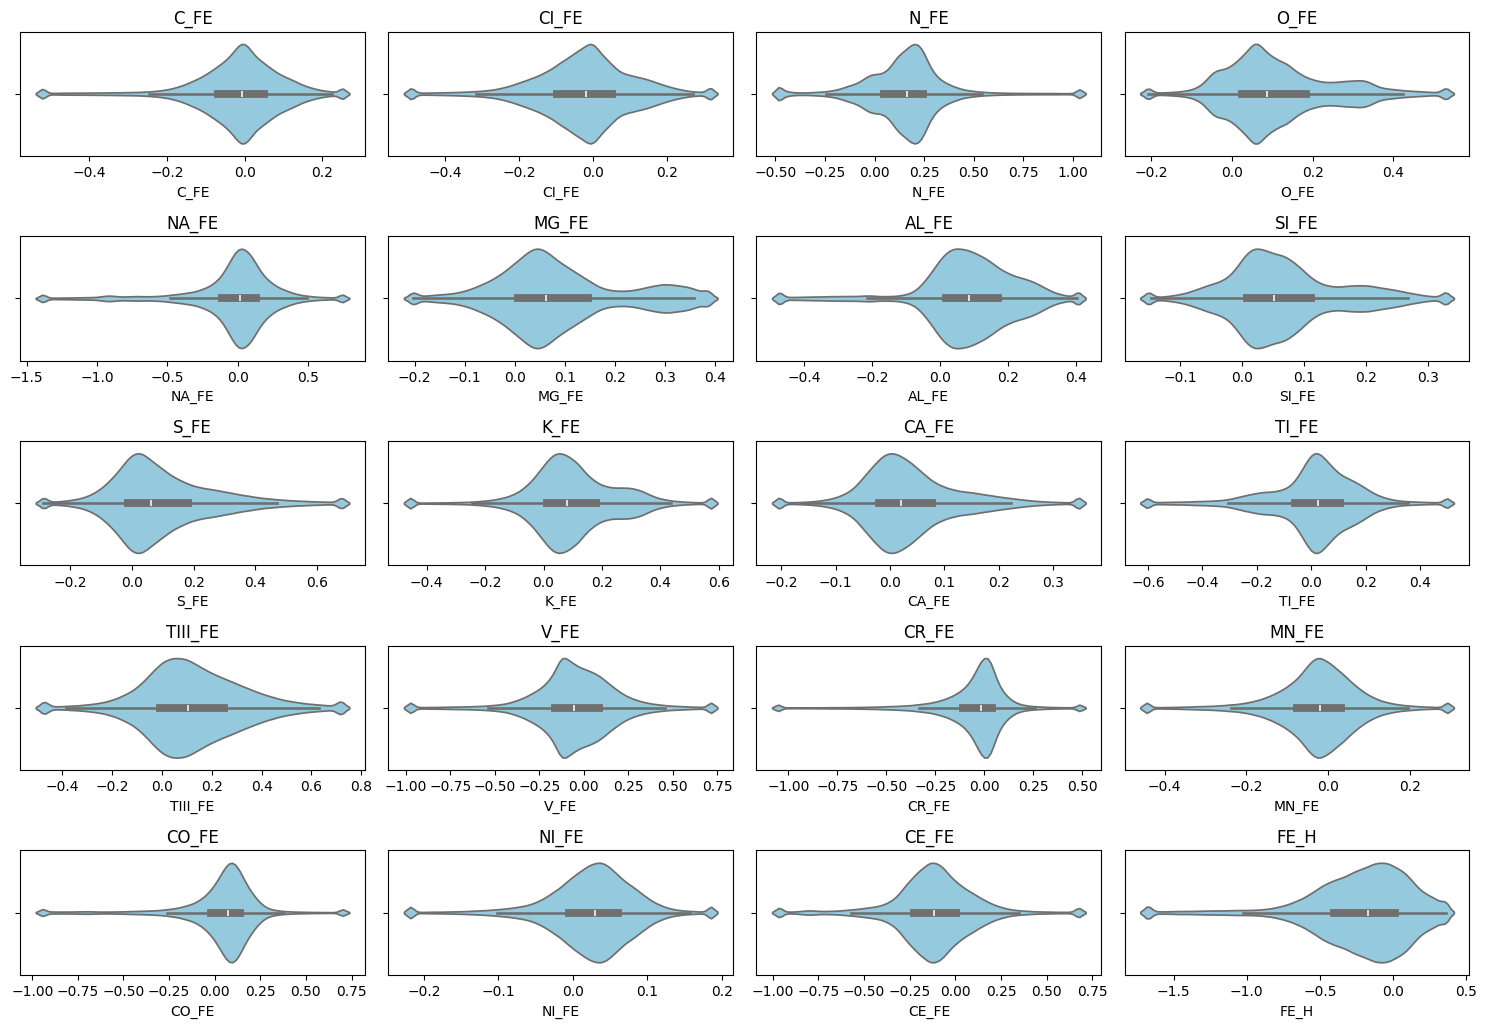

In [17]:
# Définir la taille de la figure
plt.figure(figsize=(15, 12))

# Créer un violin plot pour chaque colonne de chemical_subset
for i, column in enumerate(chemical_subset_filtered.columns, 1):
    plt.subplot(6, 4, i)
    sns.violinplot(x=chemical_subset_filtered[column], color='skyblue')
    plt.title(column)

# Ajuster l'espacement
plt.tight_layout()

# Afficher les violin plots
plt.show()


In [18]:
chemical_subset.corr(method='pearson', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.776669,-0.155308,0.251267,0.043986,0.361443,0.445123,0.253973,0.062103,0.181440,0.064941,0.283240,0.130550,0.040807,0.036246,0.091266,0.183211,0.310320,-0.062712,0.194015
CI_FE,0.776669,1.000000,-0.240384,0.387944,-0.005214,0.433609,0.439977,0.386250,0.188420,0.238042,0.182650,0.182924,0.214625,0.081544,-0.042789,-0.075701,0.127613,0.259503,-0.067568,-0.042432
N_FE,-0.155308,-0.240384,1.000000,-0.081371,0.129418,-0.074207,-0.068600,-0.022089,0.021632,0.008599,-0.048858,0.124550,-0.084941,0.000913,0.094127,0.112871,0.082925,0.004151,0.134573,-0.021196
O_FE,0.251267,0.387944,-0.081371,1.000000,-0.005937,0.735833,0.263221,0.699299,0.496943,0.351483,0.469054,0.234642,0.378816,0.103221,-0.024824,-0.386418,0.037657,0.202327,-0.140431,-0.491500
NA_FE,0.043986,-0.005214,0.129418,-0.005937,1.000000,0.072841,0.019470,0.007970,0.004771,0.073596,0.022364,0.108983,-0.050770,0.052088,0.134320,0.113241,0.148925,0.137192,-0.009874,0.037523
MG_FE,0.361443,0.433609,-0.074207,0.735833,0.072841,1.000000,0.415851,0.756919,0.545815,0.434394,0.524235,0.404755,0.424500,0.114404,0.073875,-0.313553,0.105421,0.294937,-0.125596,-0.449169
AL_FE,0.445123,0.439977,-0.068600,0.263221,0.019470,0.415851,1.000000,0.440596,0.070689,0.258228,0.237220,0.162470,0.274245,0.094147,-0.039046,-0.070674,0.064621,0.288883,-0.053357,0.080951
SI_FE,0.253973,0.386250,-0.022089,0.699299,0.007970,0.756919,0.440596,1.000000,0.478745,0.335987,0.458307,0.200050,0.405992,0.114862,-0.075259,-0.338194,0.070838,0.220578,-0.090952,-0.454281
S_FE,0.062103,0.188420,0.021632,0.496943,0.004771,0.545815,0.070689,0.478745,1.000000,0.316590,0.423916,0.193623,0.331468,0.030498,0.040016,-0.374576,0.009608,0.091340,-0.031129,-0.572522
K_FE,0.181440,0.238042,0.008599,0.351483,0.073596,0.434394,0.258228,0.335987,0.316590,1.000000,0.361394,0.248479,0.269739,0.087870,0.094449,-0.153283,0.111926,0.182937,-0.057441,-0.318533


In [19]:
chemical_subset.corr(method='kendall', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.616433,-0.150247,0.254309,0.080063,0.320101,0.289474,0.252650,0.177540,0.254480,0.101481,0.309994,0.142690,0.022192,0.057574,-0.058208,0.260641,0.324168,-0.206534,-0.018089
CI_FE,0.616433,1.000000,-0.251406,0.320976,0.031306,0.312014,0.351783,0.332160,0.216792,0.269327,0.159347,0.182734,0.199638,0.056751,-0.045982,-0.177852,0.208925,0.246137,-0.163958,-0.152923
N_FE,-0.150247,-0.251406,1.000000,-0.109420,0.128983,-0.095236,-0.145125,-0.101411,-0.020757,-0.028299,-0.109682,0.037675,-0.132269,-0.054470,0.091446,0.183657,0.032045,0.019551,0.108404,0.089231
O_FE,0.254309,0.320976,-0.109420,1.000000,-0.037262,0.574478,0.298358,0.547704,0.382875,0.330219,0.375787,0.226317,0.324445,0.073252,-0.060058,-0.359252,0.123015,0.231812,-0.118277,-0.372327
NA_FE,0.080063,0.031306,0.128983,-0.037262,1.000000,0.017835,0.018690,-0.014679,-0.029961,0.046055,-0.036580,0.095673,-0.037091,0.016870,0.089561,0.139356,0.158521,0.149830,-0.080620,0.126258
MG_FE,0.320101,0.312014,-0.095236,0.574478,0.017835,1.000000,0.343388,0.534000,0.426336,0.394833,0.442819,0.352411,0.318428,0.075653,0.046765,-0.341942,0.144835,0.311483,-0.144473,-0.357375
AL_FE,0.289474,0.351783,-0.145125,0.298358,0.018690,0.343388,1.000000,0.462280,0.143699,0.280634,0.293295,0.136905,0.258127,0.106356,-0.094665,-0.228722,0.099618,0.238592,-0.087103,-0.162686
SI_FE,0.252650,0.332160,-0.101411,0.547704,-0.014679,0.534000,0.462280,1.000000,0.309913,0.291734,0.362600,0.158385,0.334657,0.105482,-0.138002,-0.330857,0.110995,0.230254,-0.115058,-0.326181
S_FE,0.177540,0.216792,-0.020757,0.382875,-0.029961,0.426336,0.143699,0.309913,1.000000,0.327094,0.361065,0.190395,0.301396,0.009731,0.019150,-0.348334,0.059321,0.131654,-0.024134,-0.456216
K_FE,0.254480,0.269327,-0.028299,0.330219,0.046055,0.394833,0.280634,0.291734,0.327094,1.000000,0.354982,0.276863,0.262057,0.052147,0.044229,-0.263071,0.151978,0.210331,-0.110857,-0.296691


In [20]:
chemical_subset.corr(method='spearman', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.784961,-0.213652,0.368118,0.115616,0.460081,0.410410,0.365420,0.250767,0.362563,0.163898,0.439968,0.215076,0.032152,0.081745,-0.093918,0.360155,0.452961,-0.288322,-0.032772
CI_FE,0.784961,1.000000,-0.357343,0.455686,0.044390,0.448542,0.490193,0.469124,0.312446,0.387832,0.249251,0.270686,0.294283,0.082156,-0.069760,-0.260937,0.287014,0.348696,-0.230373,-0.220837
N_FE,-0.213652,-0.357343,1.000000,-0.150581,0.177706,-0.125381,-0.206580,-0.146366,-0.023742,-0.035374,-0.152046,0.064829,-0.186026,-0.079051,0.132314,0.260218,0.049921,0.032146,0.153002,0.128581
O_FE,0.368118,0.455686,-0.150581,1.000000,-0.051380,0.737649,0.411718,0.717520,0.528897,0.464845,0.518519,0.324313,0.460008,0.108251,-0.086556,-0.505256,0.169663,0.328455,-0.169355,-0.530632
NA_FE,0.115616,0.044390,0.177706,-0.051380,1.000000,0.028527,0.030171,-0.017549,-0.042104,0.067073,-0.049257,0.134280,-0.052384,0.022392,0.125473,0.193608,0.218807,0.212275,-0.113246,0.177447
MG_FE,0.460081,0.448542,-0.125381,0.737649,0.028527,1.000000,0.475315,0.700365,0.581371,0.546658,0.600124,0.490845,0.457470,0.112871,0.068249,-0.481137,0.207624,0.437009,-0.207903,-0.515955
AL_FE,0.410410,0.490193,-0.206580,0.411718,0.030171,0.475315,1.000000,0.600988,0.206323,0.397453,0.398855,0.205476,0.370522,0.152863,-0.137269,-0.308725,0.145711,0.338045,-0.124545,-0.213715
SI_FE,0.365420,0.469124,-0.146366,0.717520,-0.017549,0.700365,0.600988,1.000000,0.440902,0.421382,0.501563,0.238477,0.475754,0.152685,-0.199329,-0.467104,0.159452,0.326696,-0.165096,-0.462079
S_FE,0.250767,0.312446,-0.023742,0.528897,-0.042104,0.581371,0.206323,0.440902,1.000000,0.461791,0.508388,0.274503,0.425295,0.017030,0.031868,-0.489801,0.082862,0.187916,-0.036642,-0.629823
K_FE,0.362563,0.387832,-0.035374,0.464845,0.067073,0.546658,0.397453,0.421382,0.461791,1.000000,0.496032,0.395447,0.377373,0.076733,0.063570,-0.375957,0.215764,0.299640,-0.160925,-0.425939


In [21]:
chemical_subset.describe()

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
count,643860.000000,640781.000000,591028.000000,643504.000000,567221.000000,646291.000000,572099.000000,646151.000000,558938.000000,625849.000000,628491.000000,582657.000000,363726.000000,549071.000000,569551.000000,578038.000000,388270.000000,633827.000000,353995.000000,647042.000000
mean,-0.019660,-0.026724,0.153415,0.113316,-0.037907,0.086484,0.084597,0.066517,0.097430,0.095681,0.034549,0.010108,0.122660,-0.048044,-0.060618,-0.026615,0.033257,0.024392,-0.120582,-0.231800
std,0.136690,0.151087,0.235277,0.147854,0.362338,0.134797,0.163549,0.101628,0.182535,0.204915,0.109385,0.184133,0.219318,0.279651,0.245639,0.141188,0.265784,0.092472,0.270995,0.377003
min,-2.569600,-2.167200,-2.484940,-1.998207,-2.827178,-1.709735,-2.566144,-1.392327,-1.834437,-2.832461,-2.744315,-2.088917,-2.328021,-2.651900,-3.240002,-3.103417,-2.981460,-2.930750,-2.510510,-2.468600
25%,-0.068629,-0.096530,0.048654,0.024019,-0.114108,0.006522,0.017449,0.007887,-0.012126,0.010824,-0.020333,-0.058469,-0.006145,-0.163818,-0.109462,-0.075277,-0.019135,-0.004694,-0.228593,-0.402030
50%,-0.007691,-0.019620,0.164520,0.085721,0.017664,0.063213,0.087211,0.051817,0.061823,0.081685,0.020490,0.023871,0.105329,-0.052727,-0.018022,-0.020378,0.072580,0.029368,-0.117369,-0.171510
75%,0.049114,0.050469,0.245960,0.184313,0.128914,0.146786,0.171701,0.111780,0.181282,0.180459,0.076592,0.106538,0.247839,0.084922,0.038074,0.032915,0.141343,0.060413,0.001460,0.014171
max,1.529500,1.473540,2.791340,2.039563,2.847242,1.872143,2.931121,1.827411,2.074592,3.369369,2.137786,1.660383,1.774699,3.326362,3.309864,3.088052,3.374180,2.982033,2.913390,0.957890


In [22]:
# moyenne, écart-type, minimum, maximum, 1er quartile, médiane, 3e quartile
summary = chemical_subset.describe().loc[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
summary

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
mean,-0.019660,-0.026724,0.153415,0.113316,-0.037907,0.086484,0.084597,0.066517,0.097430,0.095681,0.034549,0.010108,0.122660,-0.048044,-0.060618,-0.026615,0.033257,0.024392,-0.120582,-0.231800
std,0.136690,0.151087,0.235277,0.147854,0.362338,0.134797,0.163549,0.101628,0.182535,0.204915,0.109385,0.184133,0.219318,0.279651,0.245639,0.141188,0.265784,0.092472,0.270995,0.377003
min,-2.569600,-2.167200,-2.484940,-1.998207,-2.827178,-1.709735,-2.566144,-1.392327,-1.834437,-2.832461,-2.744315,-2.088917,-2.328021,-2.651900,-3.240002,-3.103417,-2.981460,-2.930750,-2.510510,-2.468600
max,1.529500,1.473540,2.791340,2.039563,2.847242,1.872143,2.931121,1.827411,2.074592,3.369369,2.137786,1.660383,1.774699,3.326362,3.309864,3.088052,3.374180,2.982033,2.913390,0.957890
25%,-0.068629,-0.096530,0.048654,0.024019,-0.114108,0.006522,0.017449,0.007887,-0.012126,0.010824,-0.020333,-0.058469,-0.006145,-0.163818,-0.109462,-0.075277,-0.019135,-0.004694,-0.228593,-0.402030
50%,-0.007691,-0.019620,0.164520,0.085721,0.017664,0.063213,0.087211,0.051817,0.061823,0.081685,0.020490,0.023871,0.105329,-0.052727,-0.018022,-0.020378,0.072580,0.029368,-0.117369,-0.171510
75%,0.049114,0.050469,0.245960,0.184313,0.128914,0.146786,0.171701,0.111780,0.181282,0.180459,0.076592,0.106538,0.247839,0.084922,0.038074,0.032915,0.141343,0.060413,0.001460,0.014171


In [24]:
list(chemical_subset.columns)

['C_FE',
 'CI_FE',
 'N_FE',
 'O_FE',
 'NA_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'S_FE',
 'K_FE',
 'CA_FE',
 'TI_FE',
 'TIII_FE',
 'V_FE',
 'CR_FE',
 'MN_FE',
 'CO_FE',
 'NI_FE',
 'CE_FE',
 'FE_H']